In [10]:
import os
import math
import re
import time
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import imageio
import cv2
from IPython.display import clear_output
from PIL import Image, ImageFont, ImageDraw

In [2]:
# Importing HopSkipJump
from __future__ import absolute_import, division, print_function, unicode_literals
from art.estimators.classification import BlackBoxClassifier
from art.defences.preprocessor import JpegCompression
from art.attacks.evasion import HopSkipJump
from art.utils import to_categorical

/Users/hsahu/opt/anaconda3/envs/tf/lib/python3.7/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
# Importing Tesseract's python wrapper
import pytesseract
# Defining the path of installed Tesseract
pytesseract.pytesseract.tesseract_cmd = r'/opt/homebrew/bin/tesseract'

In [4]:
# Compress the given image to a desirable size to make the computation faster

def compress_image(img):
    ht, wid, _ = img.shape
    reduce_factor = math.ceil(ht/250)
    new_ht = int(ht/reduce_factor)
    new_wid = int(wid/reduce_factor)
    res = cv2.resize(img, dsize=(new_wid, new_ht), interpolation=cv2.INTER_CUBIC)
    print(img.shape)
    print(res.shape)
    return res

In [5]:
# Define a predict function which will call Tesseract to predict text in the given image

def predict(x):
    out_label = []
    for x_i in x:
        x_i = x_i.astype(np.uint8)
        out_string = pytesseract.image_to_string(x_i).strip()
        rmv_words_lst = ['\n']
        for rmv_word in rmv_words_lst:
            out_string = out_string.replace('\n',' ')
        out_string = re.split(', | |_|-|/|!|@|#|\?|\+', out_string)
        interest_word_lst = ['vaccine','vaccines','vaccinate','vaccinated','vaccination','vaccinations']
        found = 0
        for word in out_string:
            if word.lower() in interest_word_lst:
                found = 1
                break
        if found == 1:
            out_label.append(0)
        else:
            out_label.append(1)
    out_label_cat = to_categorical(out_label, 2)
    return out_label_cat

def predict_text(model, image, label_dict):
    plt.imshow(image[:,:,0])
    plt.show()
    image_lst = np.array([image], dtype=np.float32)
    out_label_cat = model.predict(image_lst)
    print(label_dict[np.argmax(out_label_cat)])
    return label_dict[np.argmax(out_label_cat)]

In [6]:
# Adversarial attack using HopSkipJump
'''
Optimization of adversarial image stops after either 15 iterations or 
when the consecutive error does not decrease more than 1%
'''

def create_mask(model, image_target, label_dict):
    attack = HopSkipJump(classifier=model, targeted=False, max_iter=0, max_eval=1000, init_eval=10)
    iter_step = 10
    l2_error_lst = []
    x_adv = None
    for i in range(15):
        x_adv = attack.generate(x=np.array([image_target], dtype=np.float32), x_adv_init=x_adv, resume=True)
        l2_error = np.linalg.norm(np.reshape(x_adv[0]-image_target,[-1]))
        l2_error_lst.append(l2_error)
        print("Adversarial image at step %d." % (i*iter_step))
        print("L2 error: %.6f" %l2_error)
        print("Tesseract output is: %s." % label_dict[np.argmax(model.predict(x_adv)[0])])
        plt.imshow(x_adv[0,:,:,0])
        plt.show(block=False)
        attack.max_iter = iter_step
        if i>=1 and abs(l2_error_lst[-2]-l2_error_lst[-1])/l2_error_lst[-2]<0.01:
            break
    return x_adv, l2_error_lst

In [7]:
# function to verify output on the generated adversarial image

def verify_output(adv_img):
    adv_img_copy = adv_img.astype(np.uint8)
    plt.imshow(adv_img_copy[0,:,:,:])
    print('After perturbation')
    plt.show()
    print("Tesseract output: "+pytesseract.image_to_string(adv_img_copy[0]))

In [8]:
#Text that you want to show on the image

target_word = 'vaccination'
label_dict = {0: target_word, 1: 'other'}
reverse_label_dict = {target_word: 0, 'other': 1}

1
(720, 1280, 3)
(240, 426, 3)


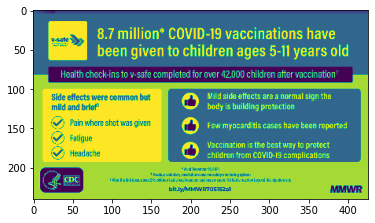

vaccination


HopSkipJump: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.93s/it]


Adversarial image at step 0.
L2 error: 8864.297852
Tesseract output is: other.


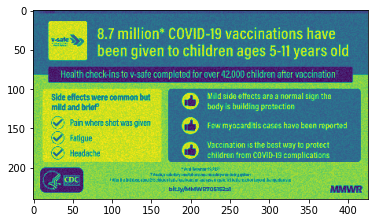

HopSkipJump: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [01:10<00:00, 70.61s/it]


Adversarial image at step 10.
L2 error: 7411.518555
Tesseract output is: other.


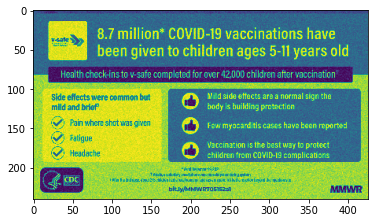

HopSkipJump: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [01:47<00:00, 107.34s/it]


Adversarial image at step 20.
L2 error: 6899.350586
Tesseract output is: other.


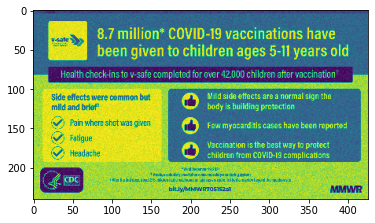

HopSkipJump: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [01:54<00:00, 114.32s/it]


Adversarial image at step 30.
L2 error: 6811.713379
Tesseract output is: other.


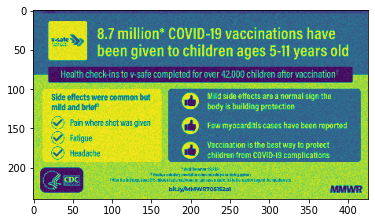

HopSkipJump: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [02:39<00:00, 159.57s/it]


Adversarial image at step 40.
L2 error: 6512.226074
Tesseract output is: other.


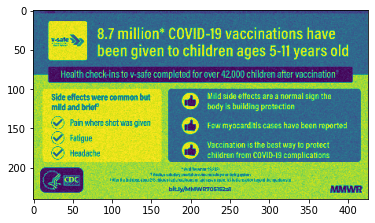

HopSkipJump: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [02:34<00:00, 154.60s/it]


Adversarial image at step 50.
L2 error: 6437.469238
Tesseract output is: other.


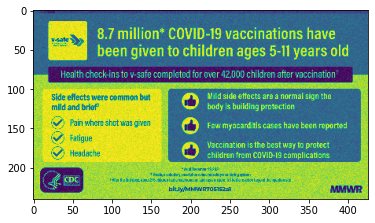

HopSkipJump: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [02:43<00:00, 163.99s/it]


Adversarial image at step 60.
L2 error: 6397.609863
Tesseract output is: other.


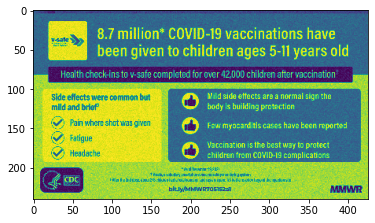

After perturbation


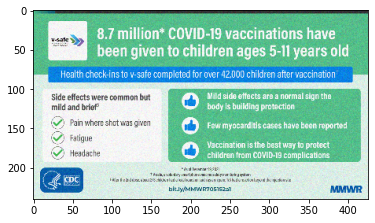

Tesseract output: Side effects were common but
mild and brit

(D) Pain where shat was given
SD taine
SD resaate

eymaneraosice



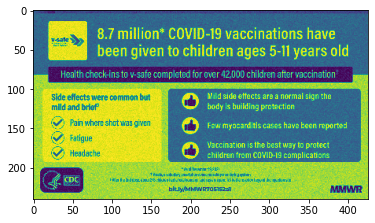

Lossy conversion from float32 to uint8. Range [0.0, 255.0]. Convert image to uint8 prior to saving to suppress this warning.


other
vaccination other
--- 783.3916516304016 seconds ---


In [13]:
# Count no. of original images which Tesseract is able to read correcctly
workable_examples = 0
workable_examples_lst = []

# Count no. of images successfully able to fool Tesseract after being perturbed
successful_examples = 0
successful_examples_lst = []

for i in range(1, 21):
    input_img_path = './Images/Vaccination_Images/vaccination_'+str(i)+'.png'
    if os.path.exists(input_img_path):
        print(i)
        #Print running time for each image
        start_time = time.time()
        image_target = imageio.imread(input_img_path)
        image_target = compress_image(image_target)
        # Define BlackBoxClassifier that uses the predict function
        model = BlackBoxClassifier(predict, image_target.shape, 2, clip_values=(0, 255))
        orig_output = predict_text(model, image_target, label_dict)
        adv_img, l2_error_lst = create_mask(model, image_target, label_dict)
        verify_output(adv_img)
        adv_output = predict_text(model, adv_img[0], label_dict)
        print(orig_output, adv_output)
        if orig_output=='vaccination':
            workable_examples += 1
            workable_examples_lst.append(i)
            if adv_output=='other':
                successful_examples += 1
                successful_examples_lst.append(i)
        # Saving the generated adversarial image
        perturbed_image_path = './Images/Untarget_attack_outputs/vaccination_'+str(i)+'_perturbed.png'
        imageio.imwrite(perturbed_image_path, adv_img[0])
        print("--- %s seconds ---" % (time.time() - start_time))